In [79]:
import VisionTransformer as vit

import copy
import datetime
import h5py
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import sys

from datetime import datetime
from gc import collect
from os import cpu_count
from sklearn.model_selection import train_test_split
from time import sleep
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary
from tqdm import tqdm

In [2]:
random_seed = 1
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
cudnn.benchmark = True

In [3]:
collect()
torch.cuda.empty_cache()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Running on device: {device}")

Running on device: cuda


## Taxonomy of an inverse problem
Ongie, G., Jalal, A., Metzler, C. A., Baraniuk, R. G., Dimakis, A. G. & Willett, R. (2020). Deep Learning Techniques for Inverse Problems in Imaging. IEEE Journal on Selected Areas in Information Theory, 1(1), 39–56. https://doi.org/10.1109/jsait.2020.2991563

<h4><center>$y = A(x) + \epsilon$</center></h4>

- $y$: measurement (e.g. displacements)
- $x$: signal (e.g. traction forces)
- $A$: (non-linear) foward operator
- $\epsilon$: noise

__Goal__: recover $x$ from $y$

__Problem__: A is ill-posed, (matrix-) inversion is not possible


__Approach__: 
  1. Supervised: create a matched dataset by simulating the forward operator on clean data
  2. Train model to reconstruct signal by taking (corrupted) measurements as input
  3. Generalize to unseen measurements

## Comparison: CNN from Kratz et al. and ViT

In [4]:
vit_weights = vit.VisionTransformer(dspl_size=104, patch_size=8, embed_dim=128, depth=12, n_heads=8, mlp_ratio=4.,p=0., attn_p=0.,drop_path=0).double()

In [5]:
if torch.cuda.is_available():
    vit_weights.load_state_dict(torch.load('logs_and_weights/ViT-2022-Nov-03 09:55:11/ViT-2022-Nov-03 09:55:11_best_val_loss_2e-05.pth')['best_model_weights'], strict=False)
else:
    vit_weights.load_state_dict(torch.load('logs_and_weights/ViT-2022-Nov-03 09:55:11/ViT-2022-Nov-03 09:55:11_best_val_loss_2e-05.pth', map_location=torch.device('cpu'))['best_model_weights'], strict=False)        

In [6]:
cnn_weights = keras.models.load_model('../mltfm/models/model_noise_1e-4.h5')

2022-11-09 15:45:01.032962: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 15:45:01.033271: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2022-11-09 15:45:01.033305: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcurand.so.10'; dlerror: libcurand.so.10: cannot open shared object file: No such file or directory
2022-11-09 15:45:01.033335: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2022-11-09 15:45:01.033363: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could no

In [7]:
dspl = h5py.File('data/displacements_25.h5')["data"]
trac = h5py.File('data/tractions_25.h5')["data"]

dspl_ = np.moveaxis(np.array(dspl),3 ,1)
trac_ = np.moveaxis(np.array(trac),3 ,1)

X_test = torch.from_numpy(dspl_).double()
Y_test = torch.from_numpy(trac_).double()

In [8]:
pred_vit, _ = vit_weights(X_test)
pred_cnn = cnn_weights.predict(dspl)

forward call of block-method: x.shape == torch.Size([25, 169, 128]), attn.shape == torch.Size([25, 8, 169, 169])
forward call of block-method: x.shape == torch.Size([25, 169, 128]), attn.shape == torch.Size([25, 8, 169, 169])
forward call of block-method: x.shape == torch.Size([25, 169, 128]), attn.shape == torch.Size([25, 8, 169, 169])
forward call of block-method: x.shape == torch.Size([25, 169, 128]), attn.shape == torch.Size([25, 8, 169, 169])
forward call of block-method: x.shape == torch.Size([25, 169, 128]), attn.shape == torch.Size([25, 8, 169, 169])
forward call of block-method: x.shape == torch.Size([25, 169, 128]), attn.shape == torch.Size([25, 8, 169, 169])
forward call of block-method: x.shape == torch.Size([25, 169, 128]), attn.shape == torch.Size([25, 8, 169, 169])
forward call of block-method: x.shape == torch.Size([25, 169, 128]), attn.shape == torch.Size([25, 8, 169, 169])
forward call of block-method: x.shape == torch.Size([25, 169, 128]), attn.shape == torch.Size([2

In [9]:
loss = torch.nn.MSELoss(reduction='none')
loss_vit = torch.sum(loss(pred_vit, Y_test), (1, 2, 3))
loss_cnn = torch.sum(loss(torch.tensor(np.moveaxis(pred_cnn, 3, 1)), Y_test), (1, 2, 3))

loss_vit = torch.reshape(loss_vit, (25, 1))
loss_cnn = torch.reshape(loss_cnn, (25, 1))

In [10]:
pd.DataFrame(np.array(torch.cat((loss_vit, loss_cnn), 1).detach().numpy()), columns=['loss_ViT', 'loss_CNN'])

loss_ViT  loss_CNN
0   2.753814  0.953331
1   4.901701  2.071338
2   2.239506  0.819685
3   2.465992  1.019594
4   3.118751  1.171545
5   4.250527  1.809745
6   2.809118  1.016019
7   5.284278  2.160380
8   3.905215  1.641007
9   6.274332  2.361687
10  2.118393  0.882499
11  5.836583  2.435076
12  2.805128  1.104939
13  3.904149  1.096353
14  4.696601  2.039140
15  3.914951  1.749879
16  3.102587  1.241891
17  2.278443  1.051531
18  3.439640  1.436726
19  2.816243  1.241582
20  6.012573  1.953751
21  3.425923  1.098681
22  2.079837  0.826820
23  2.525014  0.999485
24  3.427333  1.288314

<IPython.core.display.Javascript object>


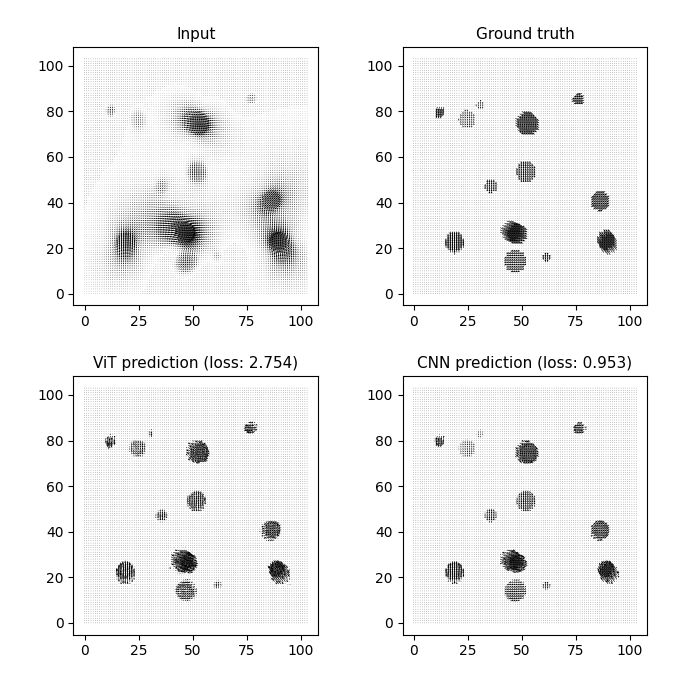

Text(0.5, 1.0, 'CNN prediction (loss: 0.953)')

In [11]:
get_ipython().run_line_magic('matplotlib', 'notebook')

# Plots
fig, axs = plt.subplots(2,2, figsize=(7, 7))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)
axs[0, 0].quiver(dspl[0,:,:,0], dspl[0,:,:,1], scale=1)
axs[0, 0].set_title('Input', {'fontsize': 11})

axs[0, 1].quiver(trac[0,:,:,0], trac[0,:,:,1], scale=10)
axs[0, 1].set_title('Ground truth', {'fontsize': 11})

axs[1, 0].quiver(pred_vit[0,0,:,:].detach().numpy(), pred_vit[0,1,:,:].detach().numpy(), scale=10)
axs[1, 0].set_title(f'ViT prediction (loss: {torch.round(loss_vit[0,0], decimals=3)})', {'fontsize': 11})

axs[1, 1].quiver(pred_cnn[0,:,:,0], pred_cnn[0,:,:,1], scale=10)
axs[1, 1].set_title(f'CNN prediction (loss: {torch.round(loss_cnn[0,0], decimals=3)})', {'fontsize': 11})

## Optimization possibilities

- Complexity of decoder (linear layer, FFNN, Convolutions, 'proper' decoder)
- Pretraining on low-resolution samples and finetuning on high resolution
- Multitask learning:
        - MSE
        - Classification: Split dataset in three groups, corrupt each group with Gaussian noise of different magnitude, infer label
        - Deviation of Traction Magnitude at Adhesions (DTMA)
        - Deviation of Traction Magnitude in the Background (DTMB)
        - Signal to Noise Ratio (SNR)
        - Deviation of Traction Direction at Adhesions (DDA)
- Hyperparameters: 
        - Depth of encoder/decoder
        - patch size
        - embedding dimension
        - number of attention heads
        - mlp ratio (number of hidden layers in MLP module)
        - dropout, attention dropout and stochastic path prob
        - weight initialization
        - optimizer
        - learning rate schedule
        - ... 

## Visualizing attention maps

Get attention scores of each layer for an input sample.

In [90]:
from data_preparation import matFiles_to_npArray

In [95]:
os.getcwd()

'/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM'

In [111]:
X_test = matFiles_to_npArray('../comparables/generic')[1] # each dict has keys ['brdx', 'brdy', 'dspl', 'name']
Y_test = matFiles_to_npArray('../comparables/generic')[0] # each dict has keys ['brdx', 'brdy', 'dspl', 'name']

In [112]:
X_test['dspl'].shape

(104, 104, 2)

In [113]:
X_test = np.moveaxis(np.array(X_test['dspl'])[np.newaxis, ...], 3, 1)

In [114]:
X_test.shape

(1, 2, 104, 104)

In [115]:
_, attn_scores = vit_weights(torch.tensor(X_test).double())

forward call of block-method: x.shape == torch.Size([1, 169, 128]), attn.shape == torch.Size([1, 8, 169, 169])
forward call of block-method: x.shape == torch.Size([1, 169, 128]), attn.shape == torch.Size([1, 8, 169, 169])
forward call of block-method: x.shape == torch.Size([1, 169, 128]), attn.shape == torch.Size([1, 8, 169, 169])
forward call of block-method: x.shape == torch.Size([1, 169, 128]), attn.shape == torch.Size([1, 8, 169, 169])
forward call of block-method: x.shape == torch.Size([1, 169, 128]), attn.shape == torch.Size([1, 8, 169, 169])
forward call of block-method: x.shape == torch.Size([1, 169, 128]), attn.shape == torch.Size([1, 8, 169, 169])
forward call of block-method: x.shape == torch.Size([1, 169, 128]), attn.shape == torch.Size([1, 8, 169, 169])
forward call of block-method: x.shape == torch.Size([1, 169, 128]), attn.shape == torch.Size([1, 8, 169, 169])
forward call of block-method: x.shape == torch.Size([1, 169, 128]), attn.shape == torch.Size([1, 8, 169, 169])
f

In [116]:
len(attn_scores)

12

In [117]:
attn_scores[0].shape

torch.Size([1, 8, 169, 169])

In [118]:
att_mat = torch.stack(attn_scores)

In [119]:
att_mat.shape

torch.Size([12, 1, 8, 169, 169])

In [120]:
att_mat = att_mat.squeeze(1)

# Average the attention weights across all heads.
att_mat = torch.mean(att_mat, dim=1)

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(att_mat.size(1))
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0].double()

In [121]:
for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = aug_att_mat[n].double() @ joint_attentions[n-1].double()

last_att = joint_attentions[-1]

In [122]:
grid_size = int(np.sqrt(aug_att_mat.size(-1)))

In [123]:
grid_size

13

In [124]:
last_att[0, 0:].shape

torch.Size([169])

In [125]:
mask = last_att[0, 0:].reshape(grid_size, grid_size).detach().numpy()

In [126]:
import cv2

In [127]:
mask = cv2.resize(mask / mask.max(), (104, 104))

In [128]:
mask.shape

(104, 104)

In [129]:
mask_ = mask[np.newaxis, ...]

In [130]:
mask_.shape

(1, 104, 104)

In [131]:
res = torch.tensor(mask_) * X_test[0,:,:,:]

In [132]:
res.shape

torch.Size([2, 104, 104])

<IPython.core.display.Javascript object>


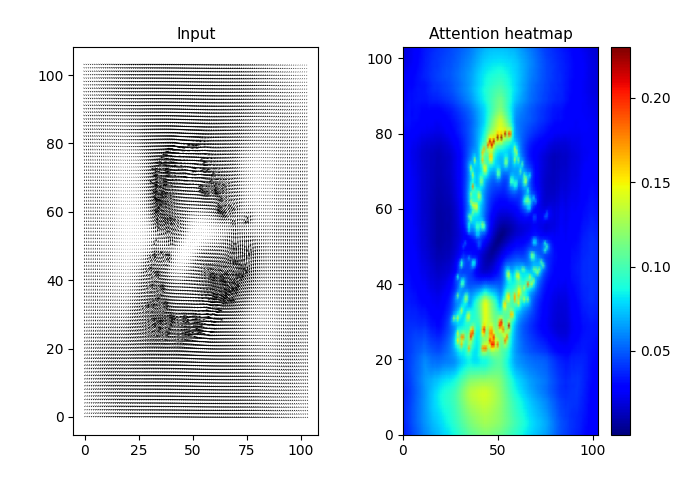

Text(0.5, 1.0, 'Attention heatmap')

In [137]:
get_ipython().run_line_magic('matplotlib', 'notebook')

# Plots
fig, axs = plt.subplots(1,2, figsize=(7, 5))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)
axs[0].quiver(X_test[0,0,:,:], X_test[0,1,:,:], scale=10)
axs[0].set_title('Input', {'fontsize': 11})

C = np.sqrt(res[0,:,:] **2 + res[1,:,:] ** 2)
im = axs[1].pcolormesh(C, cmap='jet', shading='gouraud')
fig.colorbar(im, ax=axs[1])
axs[1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[1].set_title('Attention heatmap', {'fontsize': 11})

In [153]:
joint_attentions[0, 0:] == joint_attentions[1, 0:]

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

<IPython.core.display.Javascript object>


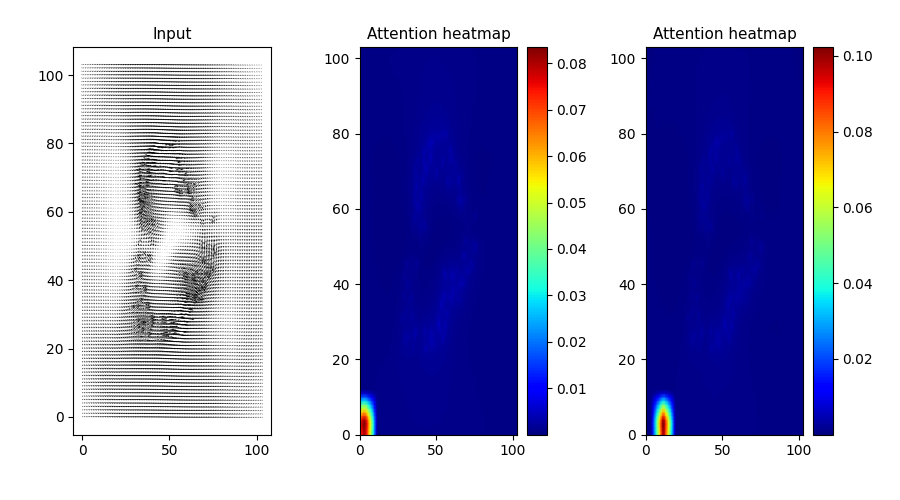

<IPython.core.display.Javascript object>


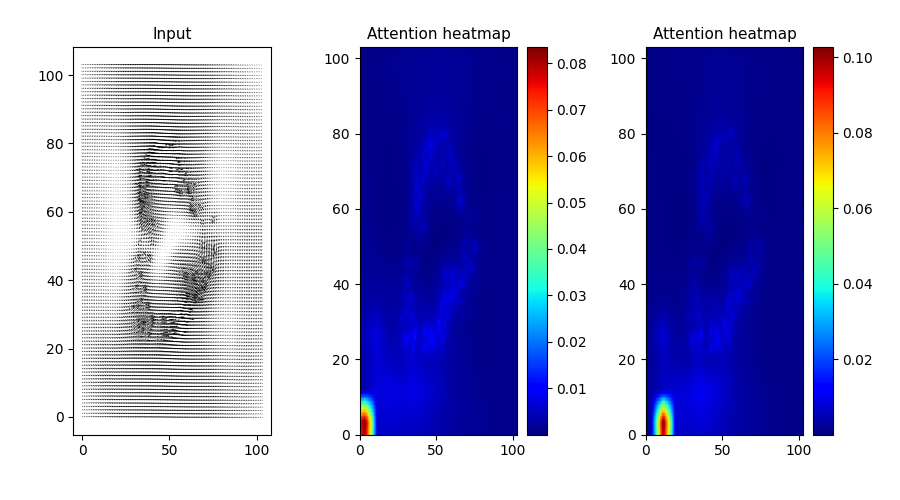

<IPython.core.display.Javascript object>


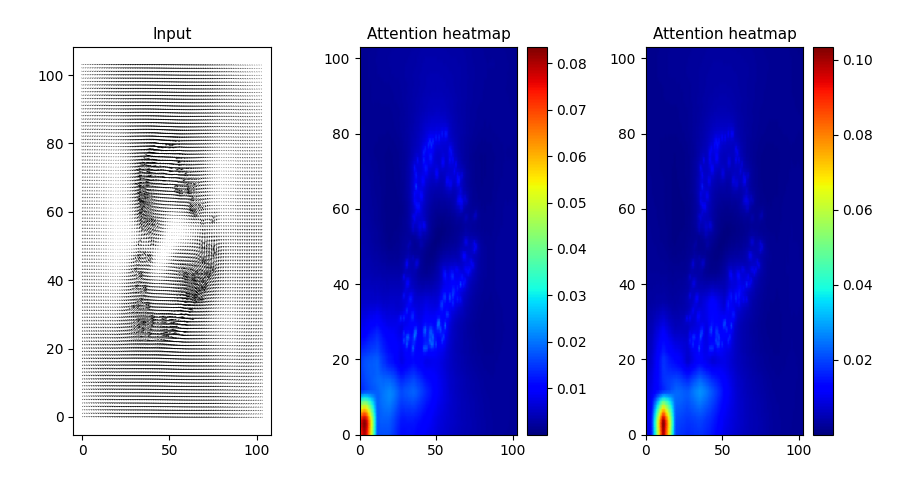

<IPython.core.display.Javascript object>


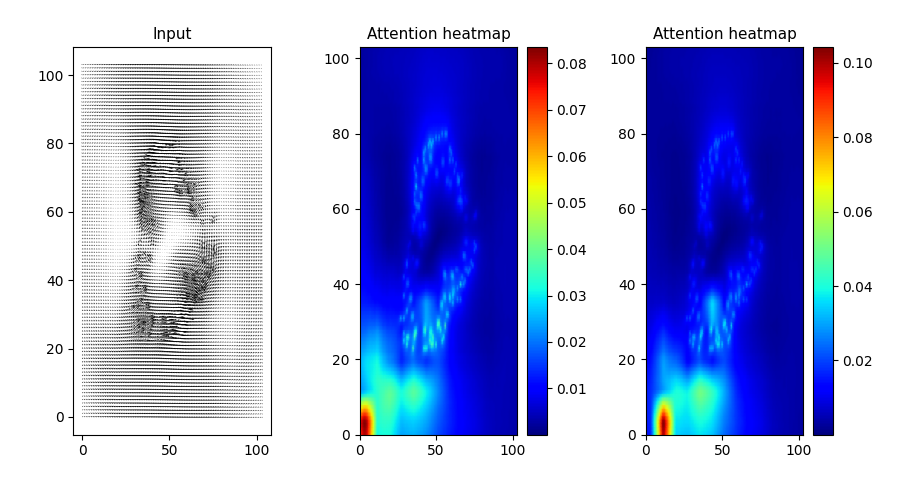

<IPython.core.display.Javascript object>


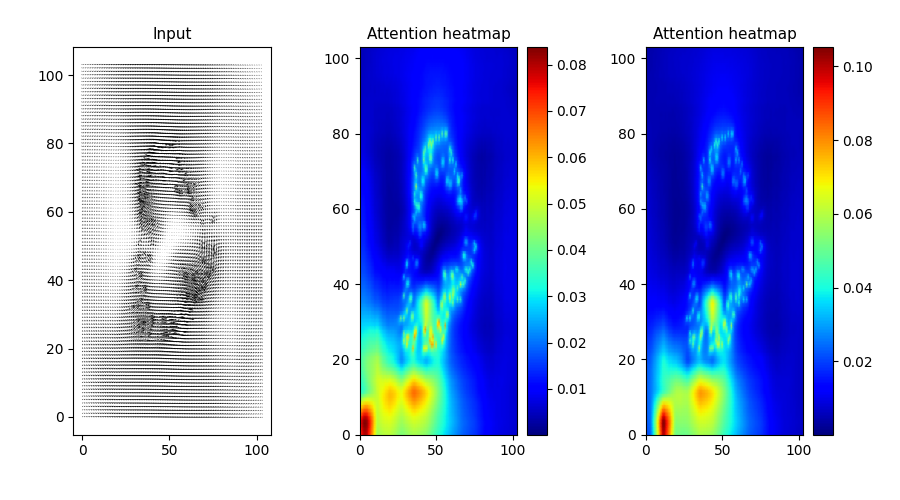

<IPython.core.display.Javascript object>


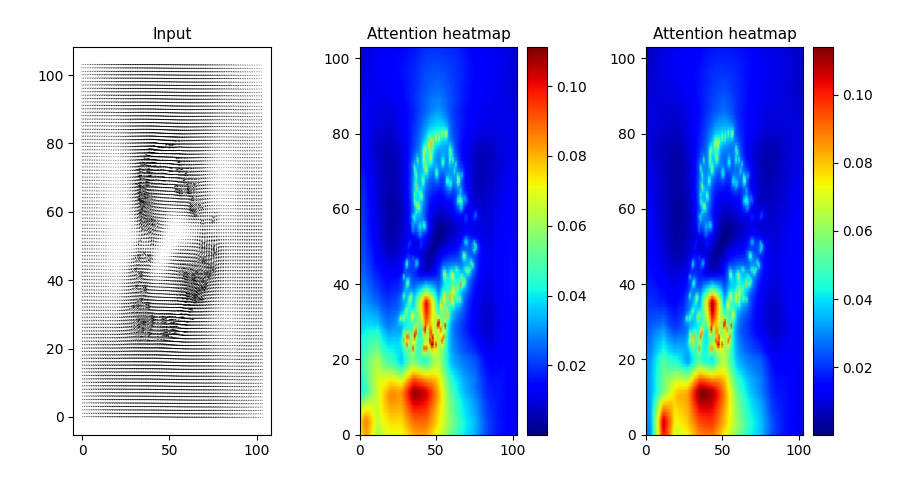

<IPython.core.display.Javascript object>


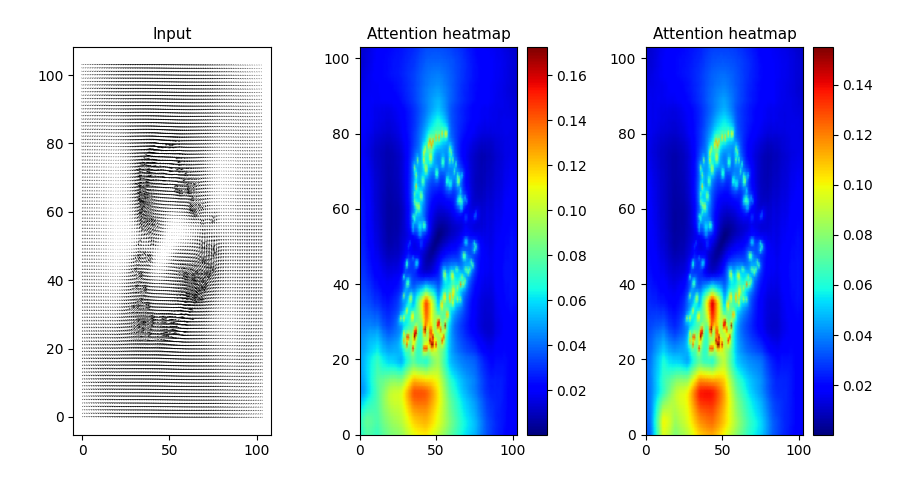

<IPython.core.display.Javascript object>


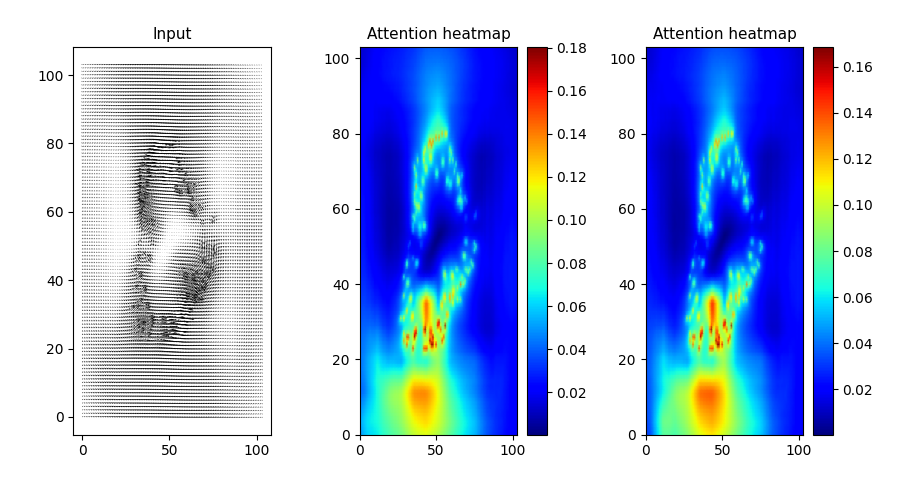

<IPython.core.display.Javascript object>


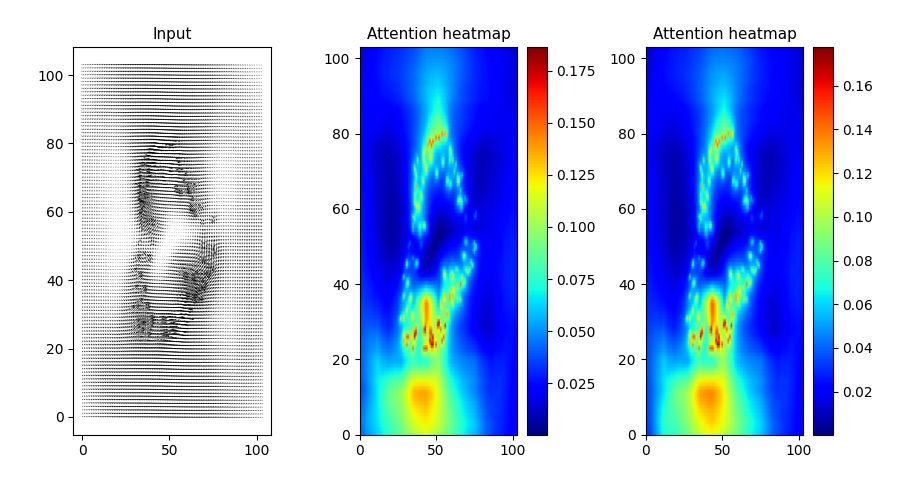

<IPython.core.display.Javascript object>


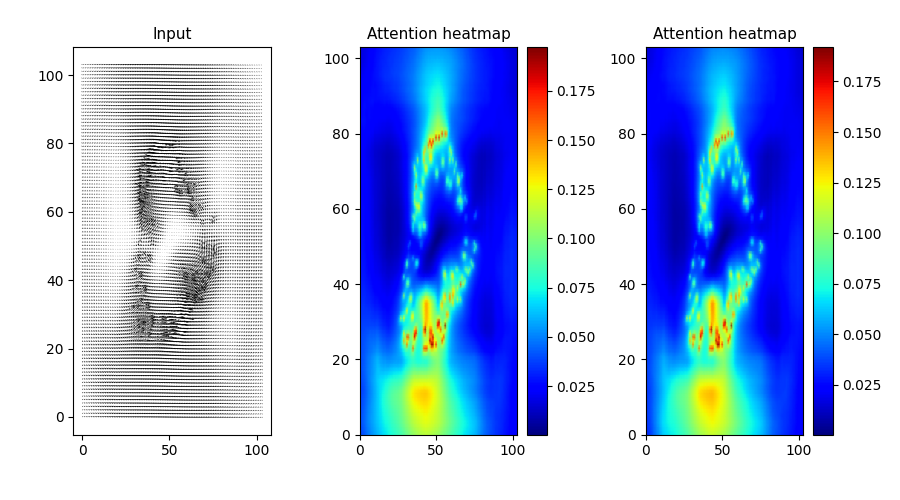

<IPython.core.display.Javascript object>


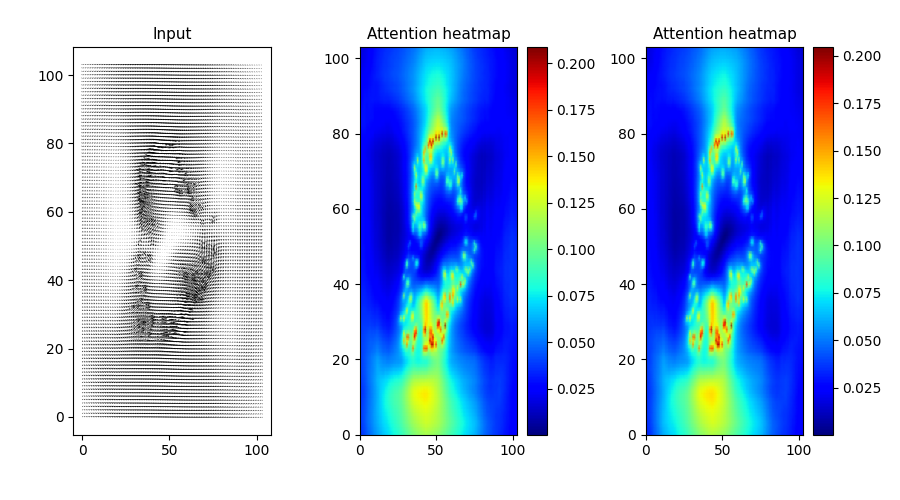

<IPython.core.display.Javascript object>


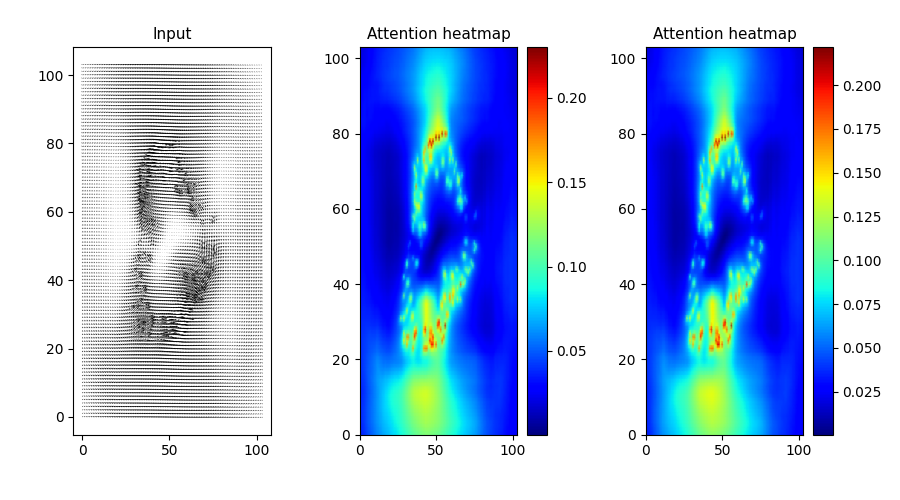

In [155]:
for i, v in enumerate(joint_attentions):
    # Attention from the output token to the input space.
    mask = v[0, 0:].reshape(grid_size, grid_size).detach().numpy()
    mask = cv2.resize(mask / mask.max(), (104, 104))
    mask = mask[np.newaxis, ...]
    result = torch.tensor(mask) * X_test[0,:,:,:]

    fig, axs = plt.subplots(1,3, figsize=(9, 5))
    fig.tight_layout(pad=3, w_pad=3, h_pad=3)
    axs[0].quiver(X_test[0,0,:,:], X_test[0,1,:,:], scale=10)
    axs[0].set_title('Input', {'fontsize': 11})

    C = np.sqrt(result[0,:,:] **2 + result[1,:,:] ** 2)
    im = axs[1].pcolormesh(C, cmap='jet', shading='gouraud')
    fig.colorbar(im, ax=axs[1])
    axs[1].pcolormesh(C, cmap='jet', shading='gouraud')
    axs[1].set_title('Attention heatmap', {'fontsize': 11})
    
    mask_ = v[1, 0:].reshape(grid_size, grid_size).detach().numpy()
    mask_ = cv2.resize(mask_ / mask_.max(), (104, 104))
    mask_ = mask_[np.newaxis, ...]
    result_ = torch.tensor(mask_) * X_test[0,:,:,:]
    
    C = np.sqrt(result_[0,:,:] **2 + result_[1,:,:] ** 2)
    im = axs[2].pcolormesh(C, cmap='jet', shading='gouraud')
    fig.colorbar(im, ax=axs[2])
    axs[2].pcolormesh(C, cmap='jet', shading='gouraud')
    axs[2].set_title('Attention heatmap', {'fontsize': 11})

In [65]:
grid_size

13

In [67]:
mask = last_att.reshape(grid_size, grid_size).detach().numpy()

RuntimeError: shape '[13, 13]' is invalid for input of size 28561

In [ ]:
mask = last_att.detach().numpy().repeat(9, 1).repeat(9, 0)
mask = mask / mask.max()
mask = np.concatenate((mask[:,:, np.newaxis], mask[:,:, np.newaxis]), axis=2)

In [55]:
result = X_test[0,:,:,:] * mask

ValueError: operands could not be broadcast together with shapes (2,104,104) (1521,1521,2) 

In [324]:
last_att = joint_attentions[-1]

In [325]:
last_att.shape

torch.Size([3, 3])

In [326]:
last_att = last_att.detach().numpy()

In [327]:
last_att

array([[0.37408584, 0.3145096 , 0.31140462],
       [0.29238343, 0.38159603, 0.3260206 ],
       [0.29183707, 0.31584075, 0.3923222 ]], dtype=float32)

In [328]:
last_att.shape

(3, 3)

In [329]:
last_att = last_att.repeat(2, 1).repeat(2, 0)

In [330]:
last_att

array([[0.37408584, 0.37408584, 0.3145096 , 0.3145096 , 0.31140462,
        0.31140462],
       [0.37408584, 0.37408584, 0.3145096 , 0.3145096 , 0.31140462,
        0.31140462],
       [0.29238343, 0.29238343, 0.38159603, 0.38159603, 0.3260206 ,
        0.3260206 ],
       [0.29238343, 0.29238343, 0.38159603, 0.38159603, 0.3260206 ,
        0.3260206 ],
       [0.29183707, 0.29183707, 0.31584075, 0.31584075, 0.3923222 ,
        0.3923222 ],
       [0.29183707, 0.29183707, 0.31584075, 0.31584075, 0.3923222 ,
        0.3923222 ]], dtype=float32)

In [331]:
last_att.shape

(6, 6)

In [332]:
last_att = np.concatenate((last_att[:,:, np.newaxis], last_att[:,:, np.newaxis]), axis=2)

In [333]:
last_att.shape

(6, 6, 2)

In [334]:
last_att[:,:,0] == last_att[:,:,1],

(array([[ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True]]),)

In [335]:
last_att[:,:,0]

array([[0.37408584, 0.37408584, 0.3145096 , 0.3145096 , 0.31140462,
        0.31140462],
       [0.37408584, 0.37408584, 0.3145096 , 0.3145096 , 0.31140462,
        0.31140462],
       [0.29238343, 0.29238343, 0.38159603, 0.38159603, 0.3260206 ,
        0.3260206 ],
       [0.29238343, 0.29238343, 0.38159603, 0.38159603, 0.3260206 ,
        0.3260206 ],
       [0.29183707, 0.29183707, 0.31584075, 0.31584075, 0.3923222 ,
        0.3923222 ],
       [0.29183707, 0.29183707, 0.31584075, 0.31584075, 0.3923222 ,
        0.3923222 ]], dtype=float32)

In [336]:
last_att[0,:,0]

array([0.37408584, 0.37408584, 0.3145096 , 0.3145096 , 0.31140462,
       0.31140462], dtype=float32)

In [337]:
sample = np.full((6,6,2),fill_value=1)

In [338]:
sample.shape

(6, 6, 2)

In [340]:
res = sample * last_att

In [341]:
res[:,:,0]

array([[0.37408584, 0.37408584, 0.3145096 , 0.3145096 , 0.31140462,
        0.31140462],
       [0.37408584, 0.37408584, 0.3145096 , 0.3145096 , 0.31140462,
        0.31140462],
       [0.29238343, 0.29238343, 0.38159603, 0.38159603, 0.3260206 ,
        0.3260206 ],
       [0.29238343, 0.29238343, 0.38159603, 0.38159603, 0.3260206 ,
        0.3260206 ],
       [0.29183707, 0.29183707, 0.31584075, 0.31584075, 0.39232221,
        0.39232221],
       [0.29183707, 0.29183707, 0.31584075, 0.31584075, 0.39232221,
        0.39232221]])